In [1]:
### Creating slope maps from elevation

import geopandas as gpd
import rasterio
from rasterio.mask import mask

from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling

from shapely.geometry import box
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

import richdem as rd
from scipy.ndimage import generic_filter

# Load the shapefile
elevation = rasterio.open("capas/topografia/elevation.tif")
elevation.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [2]:

src_path = "capas/topografia/elevation.tif"
dst_path = "capas/topografia/elevation_utm.tif"
dst_crs = "EPSG:32719"  # UTM 19S for central Chile

with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    profile = src.profile.copy()
    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dst_path, 'w', **profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

In [3]:
regions = gpd.read_file("Regiones/Regional.shp")
regions = regions.to_crs(elevation.crs)

In [4]:

#included_regions = ['Región de Coquimbo','Región de Valparaíso','Región Metropolitana de Santiago','Región de La Araucanía','Región del Bío-Bío','Región de Ñuble','Región del Maule']
included_regions = ['Región del Maule']

roi = regions[regions['Region'].isin(included_regions)] 

Text(0.5, 1.0, 'Mediterranean Chile Elevation Map')

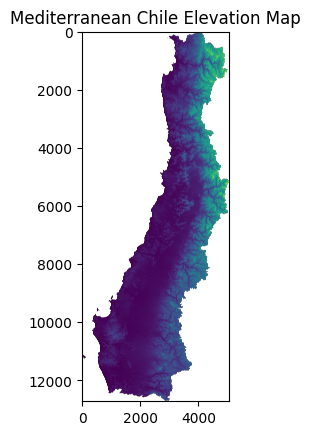

In [35]:
plt.imshow(elevation.read(1))
plt.title("Mediterranean Chile Elevation Map")

In [5]:
elevation.shape

(12720, 5043)

In [6]:
np.nanmean(elevation.read(1))

1038.3456

In [7]:
# Use RichDem package to calculate

with rasterio.open(dst_path) as src:
    elevation = src.read(1, masked=True)
    profile = src.profile
    transform = src.transform

# Calculate Slope and aspect using richdem
elevation_rd = rd.rdarray(elevation.filled(np.nan), no_data=np.nan)
elevation_rd.projection = profile['crs'].to_string()
elevation_rd.geotransform = src.transform.to_gdal()

slope = rd.TerrainAttribute(elevation_rd, attrib='slope_degrees')
aspect = rd.TerrainAttribute(elevation_rd, attrib='aspect')


def save_raster(filename, array, profile):
    with rasterio.open(filename, "w", **profile) as dst:
        dst.write(array.astype(profile['dtype']), 1)

profile.update(dtype="float32", nodata=np.nan)

save_raster("capas/topografia/slope.tif", slope, profile)
save_raster("capas/topografia/aspect.tif", aspect, profile)



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.27012                         ] (28% - 3.2s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.99202                         ] (28% - 5.1s - 1 threads))


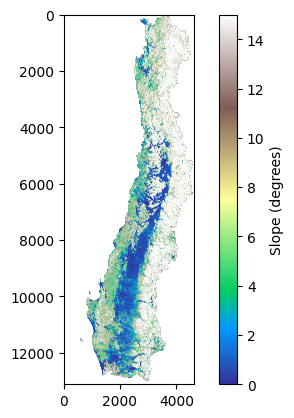

In [8]:
slope = rasterio.open('capas/topografia/slope.tif')
plt.imshow(slope.read(1), cmap='terrain', vmin=0, vmax=15)  # adjust vmax to reveal subtle changes
plt.colorbar(label='Slope (degrees)')

# Gut check: slope higher in mountains, flat in valley .

In [49]:
np.nanmax(slope.read(1))

# Gut check 2: maximum slope is 71 degrees

71.94943

Text(0.5, 1.0, 'Aspect')

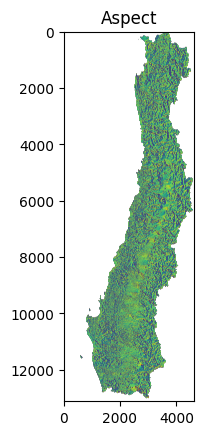

In [4]:
## Visualize aspect (degrees of north)

aspect = rasterio.open('capas/topografia/aspect.tif')

plt.imshow(aspect.read(1))
plt.title("Aspect")

EPSG:32719


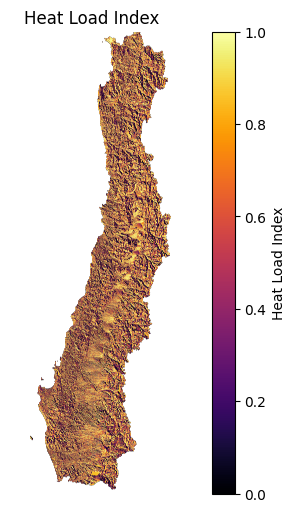

In [48]:
## Calculate heat load using equation from McCune, Bruce et al article

with rasterio.open('capas/topografia/aspect.tif') as src:
    aspect_data = src.read(1)
    aspect_data = np.ma.masked_where(aspect_data == src.nodata, aspect_data)  # Mask NoData
    profile = src.profile
    print(src.crs)

hli = (1 - np.cos(np.radians(aspect_data - 45))) / 2

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(hli, cmap='inferno')
plt.colorbar(label='Heat Load Index')
plt.title('Heat Load Index')
plt.axis('off')
plt.show()

# Save to new file

with rasterio.open('capas/topografia/heat_load.tif', 'w', **profile) as dst:
    dst.write(hli.filled(np.nan).astype('float32'), 1)  # Use np.nan for NoData values

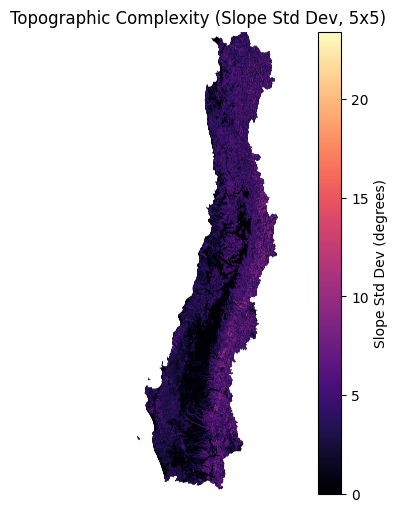

In [15]:
### Calculate topographical complexity as sd of slop in region

# Load data
with rasterio.open("capas/topografia/slope.tif") as src:
    slope = src.read(1)
    profile = src.profile

# 24 neighboring picels
window_size = 5

# Compute the standard deviation in the window
complexity = generic_filter(slope, np.std, size=window_size)

# visualization
plt.figure(figsize=(10, 6))
plt.imshow(complexity, cmap='magma')
plt.title(f"Topographic Complexity (Slope Std Dev, {window_size}x{window_size})")
plt.colorbar(label='Slope Std Dev (degrees)')
plt.axis('off')
plt.show()

# Save
profile.update(dtype=rasterio.float32)
with rasterio.open("capas/topografia/topo_complexity.tif", "w", **profile) as dst:
    dst.write(complexity.astype(np.float32), 1)


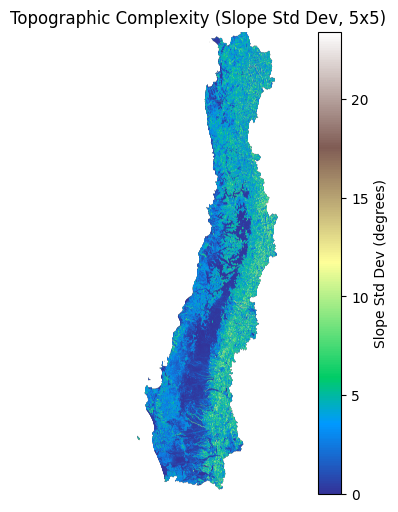

In [16]:
plt.figure(figsize=(10, 6))
plt.imshow(complexity, cmap='terrain')
plt.title(f"Topographic Complexity (Slope Std Dev, {window_size}x{window_size})")
plt.colorbar(label='Slope Std Dev (degrees)')
plt.axis('off')
plt.show()

In [5]:
# Crop to maule (For Abby)

roi = roi.to_crs(elevation.crs)
roi.crs

NameError: name 'aspect' is not defined

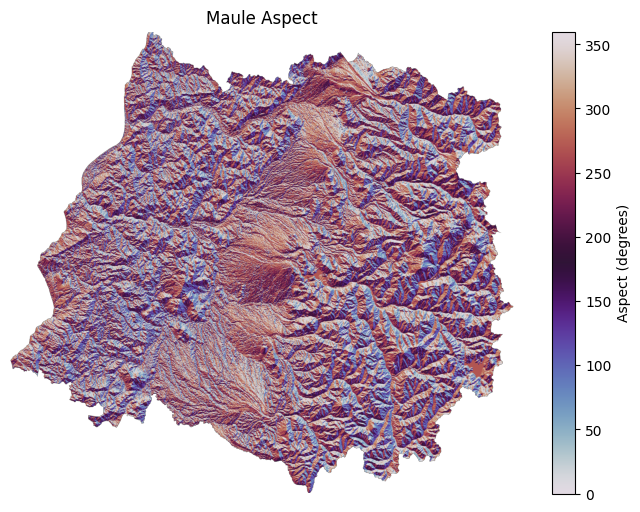

In [9]:

with rasterio.open('capas/topografia/aspect.tif') as src:
    
    # Ensure the ROI is in the same CRS as the raster
    if roi.crs != src.crs:
        roi = roi.to_crs(src.crs)
    
    # Get the geometry of the ROI
    roi_geometry = roi.geometry.values
    
    # Mask the aspect raster with the ROI geometry
    out_image, out_transform = mask(src, roi_geometry, crop=True)
    
    # Copy the metadata for the cropped raster
    out_meta = src.meta.copy()
    
    # Update metadata for the new raster
    out_meta.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": "float32",
        "crs": src.crs,
        "transform": out_transform,
        "width": out_image.shape[2],
        "height": out_image.shape[1],
        "nodata": src.nodata
    })

# Save the cropped aspect raster
with rasterio.open('capas/topografia/aspect_ML.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

# Plot the cropped aspect raster
plt.figure(figsize=(10, 6))
plt.imshow(out_image[0], cmap='twilight')
plt.title('Maule Aspect')
plt.colorbar(label='Aspect (degrees)')
plt.axis('off')
plt.show()


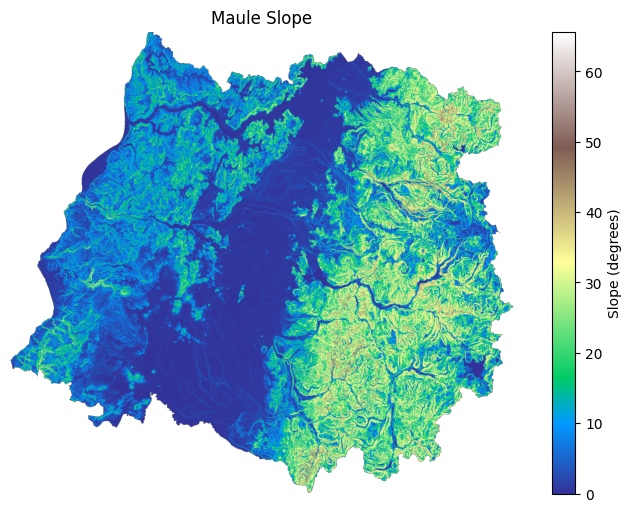

In [9]:

with rasterio.open('capas/topografia/slope.tif') as src:
    
    # Ensure the ROI is in the same CRS as the raster
    if roi.crs != src.crs:
        roi = roi.to_crs(src.crs)
    
    # Get the geometry of the ROI
    roi_geometry = roi.geometry.values
    
    # Mask the aspect raster with the ROI geometry
    out_image, out_transform = mask(src, roi_geometry, crop=True)
    
    # Copy the metadata for the cropped raster
    out_meta = src.meta.copy()
    
    # Update metadata for the new raster
    out_meta.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": "float32",
        "crs": src.crs,
        "transform": out_transform,
        "width": out_image.shape[2],
        "height": out_image.shape[1],
        "nodata": src.nodata
    })

# Save the cropped aspect raster
with rasterio.open('capas/topografia/slope_ML.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

# Plot the cropped aspect raster
plt.figure(figsize=(10, 6))
plt.imshow(out_image[0], cmap='terrain')
plt.title('Maule Slope')
plt.colorbar(label='Slope (degrees)')
plt.axis('off')
plt.show()


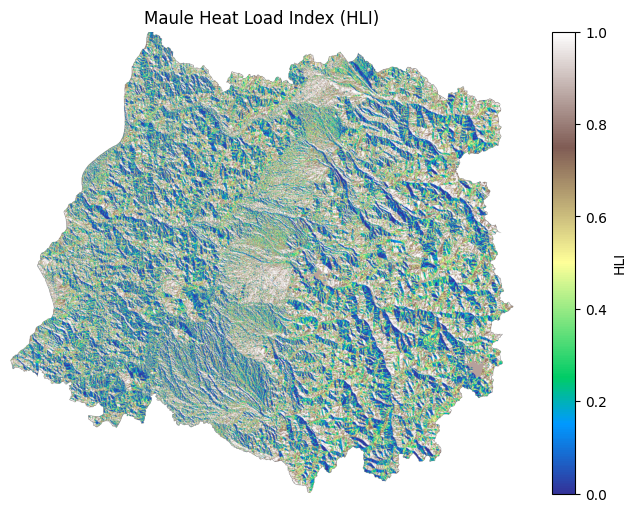

In [14]:

with rasterio.open('capas/topografia/heat_load.tif') as src:
    
    # Ensure the ROI is in the same CRS as the raster
    if roi.crs != src.crs:
        roi = roi.to_crs(src.crs)
    
    # Get the geometry of the ROI
    roi_geometry = roi.geometry.values
    
    # Mask the aspect raster with the ROI geometry
    out_image, out_transform = mask(src, roi_geometry, crop=True)
    
    # Copy the metadata for the cropped raster
    out_meta = src.meta.copy()
    
    # Update metadata for the new raster
    out_meta.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": "float32",
        "crs": src.crs,
        "transform": out_transform,
        "width": out_image.shape[2],
        "height": out_image.shape[1],
        "nodata": src.nodata
    })

# Save the cropped aspect raster
with rasterio.open('capas/topografia/heat_load_ML.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

# Plot the cropped aspect raster
plt.figure(figsize=(10, 6))
plt.imshow(out_image[0], cmap='terrain')
plt.title('Maule Heat Load Index (HLI)')
plt.colorbar(label='HLI')
plt.axis('off')
plt.show()


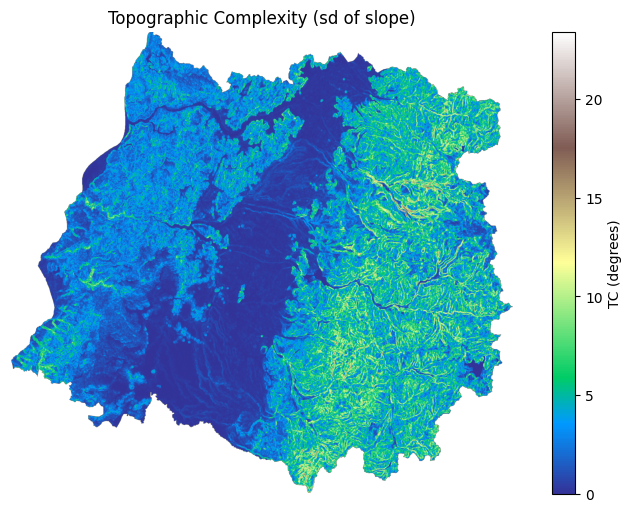

In [17]:

with rasterio.open('capas/topografia/topo_complexity.tif') as src:
    
    # Ensure the ROI is in the same CRS as the raster
    if roi.crs != src.crs:
        roi = roi.to_crs(src.crs)
    
    # Get the geometry of the ROI
    roi_geometry = roi.geometry.values
    
    # Mask the aspect raster with the ROI geometry
    out_image, out_transform = mask(src, roi_geometry, crop=True)
    
    # Copy the metadata for the cropped raster
    out_meta = src.meta.copy()
    
    # Update metadata for the new raster
    out_meta.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": "float32",
        "crs": src.crs,
        "transform": out_transform,
        "width": out_image.shape[2],
        "height": out_image.shape[1],
        "nodata": src.nodata
    })

# Save the cropped aspect raster
with rasterio.open('capas/topografia/topo_complexity_ML.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

# Plot the cropped aspect raster
plt.figure(figsize=(10, 6))
plt.imshow(out_image[0], cmap='terrain')
plt.title('Topographic Complexity (sd of slope)')
plt.colorbar(label='TC (degrees)')
plt.axis('off')
plt.show()


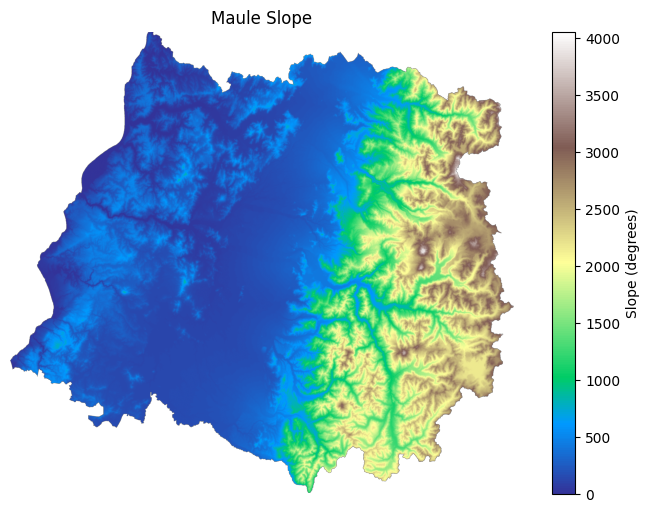

In [10]:

with rasterio.open('capas/topografia/elevation_utm.tif') as src:
    
    # Ensure the ROI is in the same CRS as the raster
    if roi.crs != src.crs:
        roi = roi.to_crs(src.crs)
    
    # Get the geometry of the ROI
    roi_geometry = roi.geometry.values
    
    # Mask the aspect raster with the ROI geometry
    out_image, out_transform = mask(src, roi_geometry, crop=True)
    
    # Copy the metadata for the cropped raster
    out_meta = src.meta.copy()
    
    # Update metadata for the new raster
    out_meta.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": "float32",
        "crs": src.crs,
        "transform": out_transform,
        "width": out_image.shape[2],
        "height": out_image.shape[1],
        "nodata": src.nodata
    })

# Save the cropped aspect raster
with rasterio.open('capas/topografia/elevation_ML.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

# Plot the cropped aspect raster
plt.figure(figsize=(10, 6))
plt.imshow(out_image[0], cmap='terrain')
plt.title('Maule Slope')
plt.colorbar(label='Slope (degrees)')
plt.axis('off')
plt.show()
